In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

# Assigning Column names while reading the dataset

In [2]:
ratings_data = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId', 'ratings', 'timestamp'])  
ratings_data.head() 

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
ratings_data.shape

(7824482, 4)

# get 10 % of the data randomly from the dataset its a huge dataset and we would run into memory issues with complete dataset

In [4]:
ratings_df = ratings_data.sample(frac=0.1, random_state=1)
ratings_df.head()

,userId,productId,ratings,timestamp
6887106,A9UYPR4Q055LZ,B00AFXUUV6,1.0,1367193600
7089171,ACUWMWOHAFDXF,B00BFDHVAS,5.0,1393545600
1257254,ADH0W9QWMJ8V7,B000OMKR8E,4.0,1228262400
5628569,A1VDA4Z5EMT052,B0075SUG3Q,5.0,1356912000
559923,ASYZVGMBYVY2Z,B0006B486K,2.0,1387324800


In [5]:
# ratings_df is our new dataset which is 10% of the original dataset
ratings_df.shape

(782448, 4)

# Drop timestamp column

In [6]:
# drop the timestamp column as its not necessary for current analysis
ratings_df.drop(['timestamp'], axis=1, inplace=True)
ratings_df.head()

,userId,productId,ratings
6887106,A9UYPR4Q055LZ,B00AFXUUV6,1.0
7089171,ACUWMWOHAFDXF,B00BFDHVAS,5.0
1257254,ADH0W9QWMJ8V7,B000OMKR8E,4.0
5628569,A1VDA4Z5EMT052,B0075SUG3Q,5.0
559923,ASYZVGMBYVY2Z,B0006B486K,2.0


# EDA on the given Dataset

In [7]:
ratings_df.describe()

,ratings
count,782448.000000
mean,4.012918
std,1.380250
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782448 entries, 6887106 to 4518419
Data columns (total 3 columns):
userId       782448 non-null object
productId    782448 non-null object
ratings      782448 non-null float64
dtypes: float64(1), object(2)
memory usage: 23.9+ MB


In [9]:
# checking for missing values
ratings_df.isna().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [10]:
# To display the value of Ratings
ratings_df['ratings'].value_counts()

5.0    434699
4.0    148863
1.0     90031
3.0     63212
2.0     45643
Name: ratings, dtype: int64

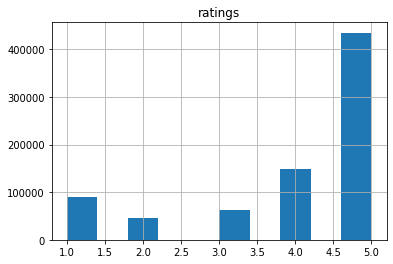

In [11]:
ratings_df.hist() 
plt.show() 

Text(0, 0.5, 'Frequency')

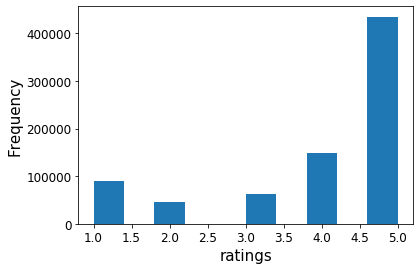

In [12]:
ratings_df['ratings'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("ratings", fontsize=15)
plt.ylabel("Frequency",fontsize=15)


The above plot shows that maximum number of customers have Rated the product as 5

In [13]:
ratings_df.head(200)

,userId,productId,ratings
6887106,A9UYPR4Q055LZ,B00AFXUUV6,1.0
7089171,ACUWMWOHAFDXF,B00BFDHVAS,5.0
1257254,ADH0W9QWMJ8V7,B000OMKR8E,4.0
5628569,A1VDA4Z5EMT052,B0075SUG3Q,5.0
559923,ASYZVGMBYVY2Z,B0006B486K,2.0
...,...,...,...
3354019,A3LQNKWTCW8227,B003GDDIW0,5.0
699584,A1H62XQWD609UE,B000A395QC,5.0
3328121,A22SIJE7PU7DRE,B003EYVHH4,1.0
2559822,A3HS7O29XZQU1J,B002DW92IE,1.0


In [14]:
ratings_df['userId'].value_counts()

A6FIAB28IS79      55
A5JLAU2ARJ0BO     51
A3OXHLG6DIBRW8    43
ADLVFFE4VBT8      42
A1ODOGXEYECQQ8    42
                  ..
A2OOYLZLTUH4DU     1
A3LLO959CZE5Y2     1
A35SJYQ4H114JY     1
A3VS1BOWAWW100     1
A3K7LJA5SFSTM1     1
Name: userId, Length: 672618, dtype: int64

# Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [15]:
# Number of unique userId  in the data
print('Number of unique users in data set = ', ratings_df['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in data set = ', ratings_df['productId'].nunique())

Number of unique users in data set =  672618
Number of unique product in data set =  166996


In [16]:
sort_userid_by__numberOfratings = ratings_df['userId'].value_counts().sort_values(ascending=False)[:20]
print(sort_userid_by__numberOfratings)

A6FIAB28IS79      55
A5JLAU2ARJ0BO     51
A3OXHLG6DIBRW8    43
ADLVFFE4VBT8      42
A1ODOGXEYECQQ8    42
A36K2N527TXXJN    34
A38KK0SZYEH5UD    34
AEJAGHLC675A7     33
AGVWTYW0ULXHT     33
A3AYSYSLHU26U9    33
A22CW0ZHY3NJH8    33
A231WM2Z2JL0U3    32
A38RMU1Y5TDP9     32
A1CMD08Z49PGKQ    31
A2AY4YUOX2N1BQ    30
AWPODHOB4GFWL     30
A4WEZJOIZIV4U     30
A1EVV74UQYVKRY    29
ARBKYIVNYWK3C     29
A17BUUBOU0598B    29
Name: userId, dtype: int64


In [17]:
userId_count = ratings_df['userId'].value_counts()
#ratings_df_denser.head()
print(len(userId_count))                 

672618


In [18]:
userId_count

A6FIAB28IS79      55
A5JLAU2ARJ0BO     51
A3OXHLG6DIBRW8    43
ADLVFFE4VBT8      42
A1ODOGXEYECQQ8    42
                  ..
A2OOYLZLTUH4DU     1
A3LLO959CZE5Y2     1
A35SJYQ4H114JY     1
A3VS1BOWAWW100     1
A3K7LJA5SFSTM1     1
Name: userId, Length: 672618, dtype: int64

In [19]:
ratings_df_final=ratings_df[ratings_df.userId.isin(userId_count[userId_count>=25].index)]
print('Number of users who have rated 25 or more items =', len(ratings_df_final))
print('Number of unique users in the final data = ', ratings_df_final['userId'].nunique())
print('Number of unique products in the final data = ', ratings_df_final['userId'].nunique())

Number of users who have rated 25 or more items = 916
Number of unique users in the final data =  28
Number of unique products in the final data =  28


In [20]:
ratings_df_final.head(5)

,userId,productId,ratings
5906689,A1ODOGXEYECQQ8,B007T9WGMA,4.0
7811851,A1ODOGXEYECQQ8,B00JGGUZRC,4.0
5033185,AEJAGHLC675A7,B005K2X8L6,4.0
2008130,A17BUUBOU0598B,B001FA1O0E,4.0
7175288,A1ODOGXEYECQQ8,B00BUMXO3C,5.0


In [21]:
#construct the pivot table
final_ratings_matrix = ratings_df_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A11KZ906QD08C5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CMD08Z49PGKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EVV74UQYVKRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
final_ratings_matrix.shape

(28, 891)

In [23]:
#calculate density of the rating marix
given_number_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given number of ratings = ', given_number_of_ratings)
possible_number_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible number of ratings = ', possible_number_of_ratings)
density = (given_number_of_ratings/possible_number_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given number of ratings =  916
possible number of ratings =  24948
density: 3.67%


# Build Popularity Recommender model

In [24]:
#Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
train_data, test_data = train_test_split(ratings_df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
4614,A1VQHH85U7PX0,9043413585,3.0
5141758,A1CMD08Z49PGKQ,B005PUZOYM,5.0
7163971,A38KK0SZYEH5UD,B00BSREPRS,4.0
2961813,A3OXHLG6DIBRW8,B002ZIMEMW,5.0
7469289,A1ODOGXEYECQQ8,B00DW9PUD8,4.0


In [25]:
train_data.shape

(641, 3)

In [26]:
test_data.shape

(275, 3)

In [27]:
users = ratings_df_final['userId'].unique()
#len(users)items = ratings_df_final['productId'].unique()
len(users)
#len(items)

28

In [28]:
#Count of userId for each unique product as recommendation score 
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,9043413585,1
1,B00000J05A,1
2,B000023VW2,1
3,B00004T1KZ,1
4,B00004TE75,1
5,B00004U8FY,1
6,B00004YBVE,1
7,B00004YKDQ,1
8,B00004Z6PI,1
9,B00004Z86J,1


In [29]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
531,B00CMJZAOI,3,1.0
35,B00007E7JU,2,2.0
256,B002B4P788,2,3.0
302,B003M8HWDA,2,4.0
363,B0053R0WWG,2,5.0


In [30]:
# Popularity based recommendation model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [31]:
# Recommendations for userId 10, 100 and 150 for example. It is User's choice
find_recom = [10,100,150]    
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

     userId   productId  score  rank
531      10  B00CMJZAOI      3   1.0
35       10  B00007E7JU      2   2.0
256      10  B002B4P788      2   3.0
302      10  B003M8HWDA      2   4.0
363      10  B0053R0WWG      2   5.0


The list of recommendations for the userId: 100

     userId   productId  score  rank
531     100  B00CMJZAOI      3   1.0
35      100  B00007E7JU      2   2.0
256     100  B002B4P788      2   3.0
302     100  B003M8HWDA      2   4.0
363     100  B0053R0WWG      2   5.0


The list of recommendations for the userId: 150

     userId   productId  score  rank
531     150  B00CMJZAOI      3   1.0
35      150  B00007E7JU      2   2.0
256     150  B002B4P788      2   3.0
302     150  B003M8HWDA      2   4.0
363     150  B0053R0WWG      2   5.0




Observation: It is a Popularity recommender model, hence all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

# Build Collaborative Filtering model

In [32]:
import copy

In [33]:
ratings_df_cf = ratings_df_final.copy()

In [34]:
ratings_df_cf.head()

,userId,productId,ratings
5906689,A1ODOGXEYECQQ8,B007T9WGMA,4.0
7811851,A1ODOGXEYECQQ8,B00JGGUZRC,4.0
5033185,AEJAGHLC675A7,B005K2X8L6,4.0
2008130,A17BUUBOU0598B,B001FA1O0E,4.0
7175288,A1ODOGXEYECQQ8,B00BUMXO3C,5.0


In [35]:
ratings_df_cf.shape

(916, 3)

# User Based Collaborative Filtering model

In [36]:
# Matrix with row per 'user' and column per 'item' 
pivot_df_cf = ratings_df_cf.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df_cf.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A11KZ906QD08C5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CMD08Z49PGKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EVV74UQYVKRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
pivot_df_cf.shape

(28, 891)

In [38]:
#define user index 
pivot_df_cf['user_index'] = np.arange(0, pivot_df_cf.shape[0], 1)
pivot_df_cf.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A11KZ906QD08C5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1CMD08Z49PGKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A1EVV74UQYVKRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [40]:
pivot_df_cf.set_index(['user_index'], inplace=True)
pivot_df_cf.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df_cf, k = 10)

In [43]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-2.93443505e-16 -8.87991489e-17 -4.58538355e-16 -2.03454388e-16
   2.83242287e-17 -1.80160948e-16  3.23550664e-17  1.01453174e-17
   1.05584012e-16  5.77659219e-17]
 [ 2.63671146e-02 -1.22383386e-15 -1.08074742e-15 -1.22408525e-01
   5.16810786e-16 -2.84279411e-16  3.47604650e-16 -9.21038912e-17
  -3.21643481e-17  1.61512741e-02]
 [-5.76900879e-17  8.33097357e-18 -1.77298060e-16  1.64159305e-16
  -5.30115858e-16 -4.71157757e-16  7.40301391e-17 -4.70217833e-16
  -9.29918242e-16 -2.19486968e-16]
 [ 8.89176198e-16 -4.65122732e-16  9.19713711e-01 -7.11139796e-15
   2.98350323e-01 -1.93928998e-15 -1.70739198e-02  2.53734729e-01
   9.32057246e-16  2.19804344e-16]
 [-4.04212351e-01  2.83034103e-14 -1.53998040e-15 -2.90531243e-01
   5.94819912e-16 -2.12725797e-16  4.47049241e-16 -9.17642031e-17
  -1.81671762e-17  2.33987418e-03]
 [ 2.53548315e-16 -1.28915026e-16  9.83840980e-03  2.66554109e-15
   8.30200600e-03 -2.43352645e-15  9.30750680e-01  3.05361383e-02
   7.9065

In [44]:
# Print sigma
print('Sigma: \n',sigma)

Sigma: 
 [25.6711379  25.82634314 26.48336067 26.91407615 27.94436113 28.39013913
 28.84488285 29.94594176 30.83828789 32.05386312]


In [45]:
# sigma is not a diagonal matrix hence need to convert it into diagonal matrix.
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[25.6711379   0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         25.82634314  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         26.48336067  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         26.91407615  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         27.94436113  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         28.39013913
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  28.84488285  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         29.94594176  0.          0.        ]
 [ 0.          0.          0.        

In [46]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-1.62978442e-02  6.12289732e-04 -2.04132973e-16 ... -6.37454256e-18
  -1.54614664e-16 -7.96817819e-18]
 [ 7.28715436e-16 -2.66492060e-17  7.65920662e-17 ... -7.79661068e-17
   2.87303881e-19 -9.74576335e-17]
 [ 1.17102876e-16 -1.66537208e-17 -6.06017104e-02 ...  7.25365806e-05
  -6.79918514e-03  9.06707257e-05]
 ...
 [ 3.08654242e-18 -8.07196034e-18  8.55802712e-03 ...  3.74554423e-04
   1.21960713e-02  4.68193029e-04]
 [-1.59710165e-17 -4.86005631e-16  1.25768826e-16 ...  3.58643942e-17
   3.93978602e-17  4.48304927e-17]
 [ 1.11282225e-05  9.34490920e-02 -2.88332579e-18 ...  9.75809483e-18
  -4.18589231e-18  1.21976185e-17]]


In [47]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df_cf.columns)
preds_df.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
0,1.231291e-16,1.650682e-16,8.712814e-16,1.578162e-30,1.508356e-30,1.508356e-30,1.885445e-30,1.885445e-30,1.885445e-30,-4.223360e-16,...,8.808801e-18,2.046344e-18,8.892926e-16,1.134014e-16,4.628586e-17,1.340452e-17,1.045926e-16,1.072361e-17,1.019837e-16,1.340452e-17
1,-1.082346e-02,4.677746e-02,5.683279e-16,7.240115e-17,-4.138588e-17,-4.138588e-17,-5.173235e-17,-5.173235e-17,-5.173235e-17,-9.394315e-17,...,1.062573e-15,2.113111e-03,1.247169e-01,1.046686e-15,4.595537e-18,3.562123e-16,-1.588722e-17,2.849698e-16,1.729920e-18,3.562123e-16
2,2.378694e-17,-6.556546e-16,-2.345190e-15,8.287403e-32,1.978515e-30,1.978515e-30,2.473144e-30,2.473144e-30,2.473144e-30,3.719673e-15,...,2.364904e-17,-3.143890e-18,-1.244397e-16,2.172475e-16,6.647835e-17,2.358583e-17,1.935984e-16,1.886867e-17,-6.541761e-17,2.358583e-17
3,2.407078e-15,2.494061e-16,2.581473e-04,-1.645007e-15,1.750945e-15,1.750945e-15,2.188681e-15,2.188681e-15,2.188681e-15,-2.747866e-16,...,9.862747e-03,-2.574363e-16,2.186943e-15,2.339052e-02,-1.325947e-02,-6.235621e-04,1.352777e-02,-4.988496e-04,-1.014744e-01,-6.235621e-04
4,1.695972e-01,-4.130880e-03,-7.881025e-16,7.114340e-16,4.071474e-15,4.071474e-15,5.089342e-15,5.089342e-15,5.089342e-15,4.177953e-17,...,-1.012106e-14,2.902623e-03,1.239008e+00,-1.201567e-14,4.753710e-15,7.621675e-16,-1.894611e-15,6.097340e-16,1.559338e-15,7.621675e-16


In [48]:
# Recommend the items with the highest predicted ratings to the users

def recommend_items(userID, pivot_df_cf, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df_cf.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [49]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df_cf, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00JGGUZRC                  0.0          0.023391
B003CT5KMO                  0.0          0.016910
B001NS828K                  0.0          0.016910
B00B5I9282                  0.0          0.016910
B006421IRW                  0.0          0.016910


In [50]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df_cf, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B0052OQ9XQ                  0.0          0.606687
B00C5B1844                  0.0          0.606687
B00IUKDBN0                  0.0          0.606687
B00IRRDHUI                  0.0          0.606687
B007Y5PQQ2                  0.0          0.606687


In [52]:
# userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df_cf, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B00007E7JU                  0.0      1.122011e-14
B00C5B1844                  0.0      9.669218e-15
B00IRRDHUI                  0.0      9.669218e-15
B00ADG5FLK                  0.0      9.669218e-15
B00FH66AW4                  0.0      9.669218e-15


It is a Collaborative recommender model, hence all the three users are given different recommendations based on users past behaviour.

# Evaluation of Collabrative recommendation mode

In [53]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
userId,,,,,,,,,,,,,,,,,,,,,
A11KZ906QD08C5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A12DQZKRKTNF5E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A17BUUBOU0598B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CMD08Z49PGKQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1EVV74UQYVKRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
9043413585    0.107143
B00000J05A    0.107143
B00000J08C    0.178571
B000023VW2    0.142857
B00003CWCI    0.142857
dtype: float64

In [55]:

# Predicted ratings 
preds_df.head()

productId,9043413585,B00000J05A,B00000J08C,B000023VW2,B00003CWCI,B00004RC2D,B00004SA30,B00004SB92,B00004SYB7,B00004T1KZ,...,B00J0CVVGQ,B00J2LIC44,B00JF0D7RE,B00JGGUZRC,B00JWV1LP6,B00JWXNT2M,B00JXFM75Y,B00JXLGE70,B00KH8QNOC,B00L3YHF6O
0,1.231291e-16,1.650682e-16,8.712814e-16,1.578162e-30,1.508356e-30,1.508356e-30,1.885445e-30,1.885445e-30,1.885445e-30,-4.223360e-16,...,8.808801e-18,2.046344e-18,8.892926e-16,1.134014e-16,4.628586e-17,1.340452e-17,1.045926e-16,1.072361e-17,1.019837e-16,1.340452e-17
1,-1.082346e-02,4.677746e-02,5.683279e-16,7.240115e-17,-4.138588e-17,-4.138588e-17,-5.173235e-17,-5.173235e-17,-5.173235e-17,-9.394315e-17,...,1.062573e-15,2.113111e-03,1.247169e-01,1.046686e-15,4.595537e-18,3.562123e-16,-1.588722e-17,2.849698e-16,1.729920e-18,3.562123e-16
2,2.378694e-17,-6.556546e-16,-2.345190e-15,8.287403e-32,1.978515e-30,1.978515e-30,2.473144e-30,2.473144e-30,2.473144e-30,3.719673e-15,...,2.364904e-17,-3.143890e-18,-1.244397e-16,2.172475e-16,6.647835e-17,2.358583e-17,1.935984e-16,1.886867e-17,-6.541761e-17,2.358583e-17
3,2.407078e-15,2.494061e-16,2.581473e-04,-1.645007e-15,1.750945e-15,1.750945e-15,2.188681e-15,2.188681e-15,2.188681e-15,-2.747866e-16,...,9.862747e-03,-2.574363e-16,2.186943e-15,2.339052e-02,-1.325947e-02,-6.235621e-04,1.352777e-02,-4.988496e-04,-1.014744e-01,-6.235621e-04
4,1.695972e-01,-4.130880e-03,-7.881025e-16,7.114340e-16,4.071474e-15,4.071474e-15,5.089342e-15,5.089342e-15,5.089342e-15,4.177953e-17,...,-1.012106e-14,2.902623e-03,1.239008e+00,-1.201567e-14,4.753710e-15,7.621675e-16,-1.894611e-15,6.097340e-16,1.559338e-15,7.621675e-16


In [56]:
# Average PREDICTED rating for each item
preds_df.mean().head()

productId
9043413585    2.390154e-02
B00000J05A    1.132707e-01
B00000J08C    1.789314e-01
B000023VW2    1.315575e-16
B00003CWCI    4.278081e-16
dtype: float64

In [58]:
rmse_df_cf = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df_cf.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df_cf.shape)
rmse_df_cf['item_index'] = np.arange(0, rmse_df_cf.shape[0], 1)
rmse_df_cf.head()

(891, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
9043413585,0.107143,2.390154e-02,0
B00000J05A,0.107143,1.132707e-01,1
B00000J08C,0.178571,1.789314e-01,2
B000023VW2,0.142857,1.315575e-16,3
B00003CWCI,0.142857,4.278081e-16,4


In [59]:
RMSE = round((((rmse_df_cf.Avg_actual_ratings - rmse_df_cf.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.10494 



# Get top - K ( K = 5) recommendations

In [60]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df_cf, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B002B4P788                  0.0          0.693465
B0053R0WWG                  0.0          0.657465
B0051GO5DQ                  0.0          0.513465
B00062QY5W                  0.0          0.513465
B00ASHU4WY                  0.0          0.513465


# Summarise your insights.

In [ ]:
#Popularity based: It is a Popularity recommender model, hence all the three users are given the same recommendations. 
#    Here, we predict the products based on the popularity. 
#    It is not personalized to particular user. It is a non-personalized recommender system.
 
#Collabrative based: It is a Collaborative recommender model, 
#    hence all the three users are given different recommendations based on users past behaviour.
    
    